<a href="https://colab.research.google.com/github/oykudemirel/DSA-210-PROJECT/blob/main/dsa210project_with_ml_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Get the tmdb list which has all the movies

import requests
import time
import pandas as pd

API_KEY = '823fecbf63a8e7692fe9329ead448aac'
base_url = "https://api.themoviedb.org/3/discover/movie"

all_movies = []

for year in range(2016, 2021):
    print(f"Processing year: {year}")
    page = 1

    while True:
        params = {
    "api_key": API_KEY,
    "primary_release_year": year,
    "sort_by": "popularity.desc",  # Sort results so we get the most relevant
    "vote_count.gte": 10,          # Only include movies with at least 10 votes
    "page": page
}


        response = requests.get(base_url, params=params)
        data = response.json()

        if 'results' not in data or len(data['results']) == 0:
            print("No results, stopping...")
            break

        for movie in data['results']:
            title = movie.get('title', '')
            release_date = movie.get('release_date', '')

            if release_date:
                year_part = int(release_date.split('-')[0])
                month_part = int(release_date.split('-')[1])
            else:
                year_part = year
                month_part = None

            all_movies.append({
                "Title": title,
                "Release Year": year_part,
                "Release Month": month_part,
                "Release Date": release_date
            })

        if page >= data.get('total_pages', 1):
            break
        page += 1
        time.sleep(0.3)


df = pd.DataFrame(all_movies)
df.to_csv("tmdb_movies_2016_2020.csv", index=False)
print(df.head())



Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
            Title  Release Year  Release Month Release Date
0  Wild Awakening          2016             10   2016-10-23
1  The Accountant          2016             10   2016-10-13
2      Your Name.          2016              8   2016-08-26
3   Hacksaw Ridge          2016             10   2016-10-07
4        Zootopia          2016              2   2016-02-11


In [ ]:
# Categorize the seasons
def categorize_season(month):
    if month in [11, 12]:
        return 'Holiday Season'
    elif month in [1, 2, 9, 10]:
        return 'Awards Season'
    elif month in [6, 7, 8]:
        return 'Summer Blockbuster'
    elif month in [3, 4, 5]:
        return 'Spring'
    else:
        return 'Other'  # For missing or weird months

df['Release Season'] = df['Release Month'].apply(categorize_season)


print(df[['Title', 'Release Year', 'Release Month', 'Release Season']].head())


            Title  Release Year  Release Month      Release Season
0  Wild Awakening          2016             10       Awards Season
1  The Accountant          2016             10       Awards Season
2      Your Name.          2016              8  Summer Blockbuster
3   Hacksaw Ridge          2016             10       Awards Season
4        Zootopia          2016              2       Awards Season


Release Season
Awards Season         6092
Spring                3678
Summer Blockbuster    3453
Holiday Season        2881
Name: count, dtype: int64


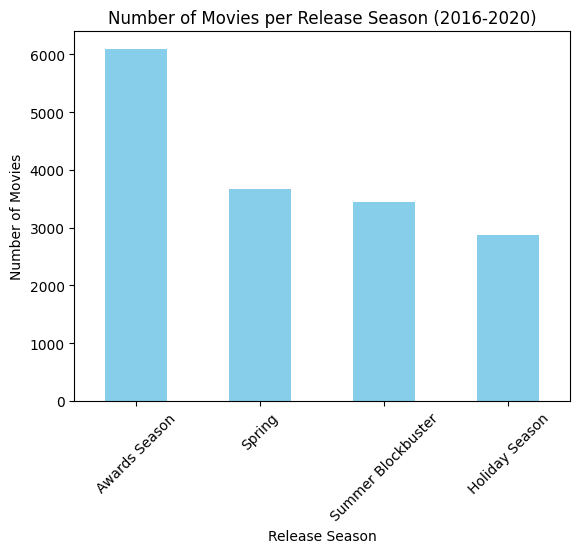

In [ ]:
# Movies per Release Season
season_counts = df['Release Season'].value_counts()
print(season_counts)


import matplotlib.pyplot as plt

season_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Release Season (2016-2020)')
plt.ylabel('Number of Movies')
plt.xlabel('Release Season')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#Web scraped the website Box Office Mojo to get the box office numbers
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

pd.set_option('display.float_format', '{:.0f}'.format)

years = list(range(2016, 2021))

base_url = "https://www.boxofficemojo.com/year/world/{year}/"


all_data = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

for year in years:
    print(f"Processing year: {year}")
    url = base_url.format(year=year)
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve data for {year}: {e}")
        continue

    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table containing the box office data
    table = soup.find('table')
    if not table:
        print(f"No table found for {year}")
        continue

    # Extract table rows, skip header row,
    rows = table.find_all('tr')[1:]

    for row in rows:
        cols = row.find_all('td')
        if len(cols) < 3:
            continue  # Skip rows that don't have enough columns
        release_group = cols[1].get_text(strip=True)
        worldwide_gross = cols[2].get_text(strip=True)
        all_data.append({
            'Year': year,o
            'Release Group': release_group,
            'Worldwide Gross': worldwide_gross
        })


    time.sleep(1)


df_box_office = pd.DataFrame(all_data)



# Remove dollar signs and commas and convert to numeric
df_box_office['Worldwide Gross'] = df_box_office['Worldwide Gross'].replace('[\$,]', '', regex=True).astype(float)


print(df_box_office.head())


Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
   Year                 Release Group  Worldwide Gross
0  2016    Captain America: Civil War       1153296293
1  2016  Rogue One: A Star Wars Story       1056057273
2  2016                  Finding Dory       1028570889
3  2016                      Zootopia       1023784195
4  2016               The Jungle Book        966550600


In [ ]:
#Normalize titles
def normalize_title(title):
    if pd.isnull(title):
        return ""
    return title.lower().strip()


df['normalized_title'] = df['Title'].apply(normalize_title)
df_box_office['normalized_title'] = df_box_office['Release Group'].apply(normalize_title)

#Merge on normalized titles and year
merged_df = pd.merge(
    df,
    df_box_office,
    left_on=['normalized_title', 'Release Year'],
    right_on=['normalized_title', 'Year'],
    how='left'
)

#Fix the _x and _y
def clean_merge_columns(df, prefer='_x'):

    for col in df.columns:
        if col.endswith(prefer):
            base = col[:-2]  # remove _x or _y
            other = base + ('_y' if prefer == '_x' else '_x')
            if other in df.columns:
                df = df.drop(columns=[other])
            df = df.rename(columns={col: base})
    return df

merged_df = clean_merge_columns(merged_df)

merged_df.drop(columns=['normalized_title', 'Year'], errors='ignore', inplace=True)

print(merged_df[['Title', 'Release Year', 'Release Month', 'Release Season', 'Worldwide Gross']].head())


            Title  Release Year  Release Month      Release Season  \
0  Wild Awakening          2016             10       Awards Season   
1  The Accountant          2016             10       Awards Season   
2      Your Name.          2016              8  Summer Blockbuster   
3   Hacksaw Ridge          2016             10       Awards Season   
4        Zootopia          2016              2       Awards Season   

   Worldwide Gross  
0              NaN  
1        155560045  
2        357986087  
3        180563636  
4       1023784195  


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oykudemirell","key":"b41ccc22de14a9a86f326e961286b890"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d unanimad/bafta-awards

!unzip -o bafta-awards.zip
!ls

Dataset URL: https://www.kaggle.com/datasets/unanimad/bafta-awards
License(s): CC0-1.0
  0% 0.00/74.5k [00:00<?, ?B/s]
100% 74.5k/74.5k [00:00<00:00, 127MB/s]
Archive:  bafta-awards.zip
  inflating: bafta_films.csv         
bafta-awards.zip  kaggle.json  tmdb_movies_2016_2020.csv
bafta_films.csv   sample_data


In [ ]:
#BAFTA Awards
import pandas as pd

df_b = pd.read_csv('bafta_films.csv')


df_b['year'] = pd.to_numeric(df_b['year'], errors='coerce')

df_b = df_b[(df_b['year'] >= 2016) & (df_b['year'] <= 2020)]

#Drop unnecessary columns
df_b = df_b.drop(columns=['category', 'workers'])

df_b.head()


,year,nominee,winner
3575,2016,The Big Short,True
3576,2016,Brooklyn,False
3577,2016,Carol,False
3578,2016,Room,False
3579,2016,Steve Jobs,False


In [ ]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"oykudemirell","key":"ebf90736d0540d12a0d387475a61f434"}'}

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp "kaggle (1).json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d unanimad/golden-globe-awards
!unzip -o golden-globe-awards.zip
!ls


Dataset URL: https://www.kaggle.com/datasets/unanimad/golden-globe-awards
License(s): CC0-1.0
  0% 0.00/117k [00:00<?, ?B/s]
100% 117k/117k [00:00<00:00, 82.6MB/s]
Archive:  golden-globe-awards.zip
  inflating: golden_globe_awards.csv  
 bafta-awards.zip	   golden-globe-awards.zip   sample_data
 bafta_films.csv	  'kaggle (1).json'	     tmdb_movies_2016_2020.csv
 golden_globe_awards.csv   kaggle.json


In [ ]:
#Golden Globe Awards
import pandas as pd


df_gg = pd.read_csv('golden_globe_awards.csv')

# Filter by year and drop unnecessary columns
df_gg['year_film'] = pd.to_numeric(df_gg['year_film'], errors='coerce')
df_gg = df_gg[(df_gg['year_film'] >= 2016) & (df_gg['year_film'] <= 2020)]

df_gg = df_gg.dropna(subset=['film'])

df_gg = df_gg.drop(columns=['year_award', 'ceremony', 'category', 'nominee'])


df_gg.head()


,year_film,film,win
7494,2016,Elle,True
7495,2016,Arrival,False
7496,2016,Miss Sloane,False
7497,2016,Loving,False
7498,2016,Jackie,False


In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"oykudemirell","key":"24fc20083ed3bb7604f8159dd18baa8c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


In [ ]:
!kaggle datasets download -d unanimad/the-oscar-award
!unzip -o the-oscar-award.zip
!ls


Dataset URL: https://www.kaggle.com/datasets/unanimad/the-oscar-award
License(s): CC0-1.0
  0% 0.00/746k [00:00<?, ?B/s]
100% 746k/746k [00:00<00:00, 657MB/s]
Archive:  the-oscar-award.zip
  inflating: full_data.csv           
  inflating: the_oscar_award.csv     
 bafta-awards.zip	   golden-globe-awards.zip   sample_data
 bafta_films.csv	  'kaggle (1).json'	     the_oscar_award.csv
 full_data.csv		  'kaggle (2).json'	     the-oscar-award.zip
 golden_globe_awards.csv   kaggle.json		     tmdb_movies_2016_2020.csv


In [ ]:
#Oscar Awards
import pandas as pd

df_oscar = pd.read_csv('the_oscar_award.csv')

df_oscar = df_oscar.drop(columns=['year_ceremony', 'ceremony', 'category', 'canon_category', 'name'], errors='ignore')


df_oscar = df_oscar[(df_oscar['year_film'] >= 2016) & (df_oscar['year_film'] <= 2020)]

df_oscar.head()


,year_film,film,winner
9984,2016,Manchester by the Sea,True
9985,2016,Hacksaw Ridge,False
9986,2016,La La Land,False
9987,2016,Captain Fantastic,False
9988,2016,Fences,False


In [ ]:
print(df_oscar.columns)
print(df_gg.columns)
print(df_b.columns)


Index(['year_film', 'film', 'winner'], dtype='object')
Index(['year_film', 'film', 'win'], dtype='object')
Index(['year', 'nominee', 'winner'], dtype='object')


In [ ]:
# Standardize columns

# Oscars
df_oscar = df_oscar.rename(columns={
    'film': 'Title',
    'year_film': 'Release Year'
})

# Golden Globes
df_gg = df_gg.rename(columns={
    'film': 'Title',
    'year_film': 'Release Year'
})

# BAFTA
df_b = df_b.rename(columns={
    'nominee': 'Title',
    'year': 'Release Year'
})



In [ ]:
print(df_oscar.columns)
print(df_gg.columns)
print(df_b.columns)


Index(['Release Year', 'Title', 'winner'], dtype='object')
Index(['Release Year', 'Title', 'win'], dtype='object')
Index(['Release Year', 'Title', 'winner'], dtype='object')


In [ ]:

def normalize_title(title):
    if pd.isna(title):
        return ''
    return title.lower().strip()

df_oscar['normalized_title'] = df_oscar['Title'].apply(normalize_title)
df_gg['normalized_title'] = df_gg['Title'].apply(normalize_title)
df_b['normalized_title'] = df_b['Title'].apply(normalize_title)

#Count how many wins each movie had per award show
df_oscar_counts = df_oscar.groupby('normalized_title').size().reset_index(name='Oscar_Win')
df_gg_counts = df_gg.groupby('normalized_title').size().reset_index(name='GG_Win')
df_b_counts = df_b.groupby('normalized_title').size().reset_index(name='BAFTA_Win')

#Merge
merged_df2 = df_oscar_counts.merge(df_gg_counts, on='normalized_title', how='outer')
merged_df2 = merged_df2.merge(df_b_counts, on='normalized_title', how='outer')

#Fill missing values with 0
merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']] = merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']].fillna(0).astype(int)

#Calculate the total number of awards won
merged_df2['Total_Awards_Won'] = merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']].sum(axis=1)


merged_df2 = merged_df2.merge(df_oscar[['normalized_title', 'Title', 'Release Year']], on='normalized_title', how='left')


merged_df2 = merged_df2.dropna(subset=['Title']).reset_index(drop=True)

print(merged_df2[['Title', 'Release Year', 'Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']].head())


                                       Title  Release Year  Oscar_Win  GG_Win  \
0  13 Hours: The Secret Soldiers of Benghazi          2016          1       0   
1                                       13th          2016          1       0   
2                                       1917          2019         10       2   
3                                       1917          2019         10       2   
4                                       1917          2019         10       2   

   BAFTA_Win  Total_Awards_Won  
0          0                 1  
1          1                 2  
2          9                21  
3          9                21  
4          9                21  


In [ ]:
print(merged_df2.columns)


Index(['normalized_title', 'Oscar_Win', 'GG_Win', 'BAFTA_Win',
       'Total_Awards_Won', 'Title', 'Release Year'],
      dtype='object')


In [ ]:
print(merged_df.columns)


Index(['Title', 'Release Year', 'Release Month', 'Release Date',
       'Release Season', 'Release Group', 'Worldwide Gross'],
      dtype='object')


In [ ]:
# Merge the clean movies/box office data (merged_df) with awards data (merged_df2)
final_df = pd.merge(
    merged_df,
    merged_df2[['Title', 'Release Year', 'Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']],
    on=['Title', 'Release Year'],
    how='left'
)

print(final_df.head())


            Title  Release Year  Release Month Release Date  \
0  Wild Awakening          2016             10   2016-10-23   
1  The Accountant          2016             10   2016-10-13   
2      Your Name.          2016              8   2016-08-26   
3   Hacksaw Ridge          2016             10   2016-10-07   
4   Hacksaw Ridge          2016             10   2016-10-07   

       Release Season   Release Group  Worldwide Gross  Oscar_Win  GG_Win  \
0       Awards Season             NaN              NaN        NaN     NaN   
1       Awards Season  The Accountant        155560045        NaN     NaN   
2  Summer Blockbuster      Your Name.        357986087        NaN     NaN   
3       Awards Season   Hacksaw Ridge        180563636          6       2   
4       Awards Season   Hacksaw Ridge        180563636          6       2   

   BAFTA_Win  Total_Awards_Won  
0        NaN               NaN  
1        NaN               NaN  
2        NaN               NaN  
3          4              

In [ ]:
# Fill NaN award counts with 0
award_cols = ['Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']
final_df[award_cols] = final_df[award_cols].fillna(0).astype(int)


final_df = final_df.drop(columns=['Release Group'])

print(final_df.head())



            Title  Release Year  Release Month Release Date  \
0  Wild Awakening          2016             10   2016-10-23   
1  The Accountant          2016             10   2016-10-13   
2      Your Name.          2016              8   2016-08-26   
3   Hacksaw Ridge          2016             10   2016-10-07   
4   Hacksaw Ridge          2016             10   2016-10-07   

       Release Season  Worldwide Gross  Oscar_Win  GG_Win  BAFTA_Win  \
0       Awards Season              NaN          0       0          0   
1       Awards Season        155560045          0       0          0   
2  Summer Blockbuster        357986087          0       0          0   
3       Awards Season        180563636          6       2          4   
4       Awards Season        180563636          6       2          4   

   Total_Awards_Won  
0                 0  
1                 0  
2                 0  
3                12  
4                12  


In [ ]:
# Filter the DataFrame to include only movies with Total_Awards_Won > 0
award_winning_movies_df = final_df[final_df['Total_Awards_Won'] > 0].copy()

print(f"Original number of movies: {len(final_df)}")
print(f"Number of award-winning movies: {len(award_winning_movies_df)}")
print(award_winning_movies_df.head())

Original number of movies: 16399
Number of award-winning movies: 535
           Title  Release Year  Release Month Release Date Release Season  \
3  Hacksaw Ridge          2016             10   2016-10-07  Awards Season   
4  Hacksaw Ridge          2016             10   2016-10-07  Awards Season   
5  Hacksaw Ridge          2016             10   2016-10-07  Awards Season   
6  Hacksaw Ridge          2016             10   2016-10-07  Awards Season   
7  Hacksaw Ridge          2016             10   2016-10-07  Awards Season   

   Worldwide Gross  Oscar_Win  GG_Win  BAFTA_Win  Total_Awards_Won  
3        180563636          6       2          4                12  
4        180563636          6       2          4                12  
5        180563636          6       2          4                12  
6        180563636          6       2          4                12  
7        180563636          6       2          4                12  


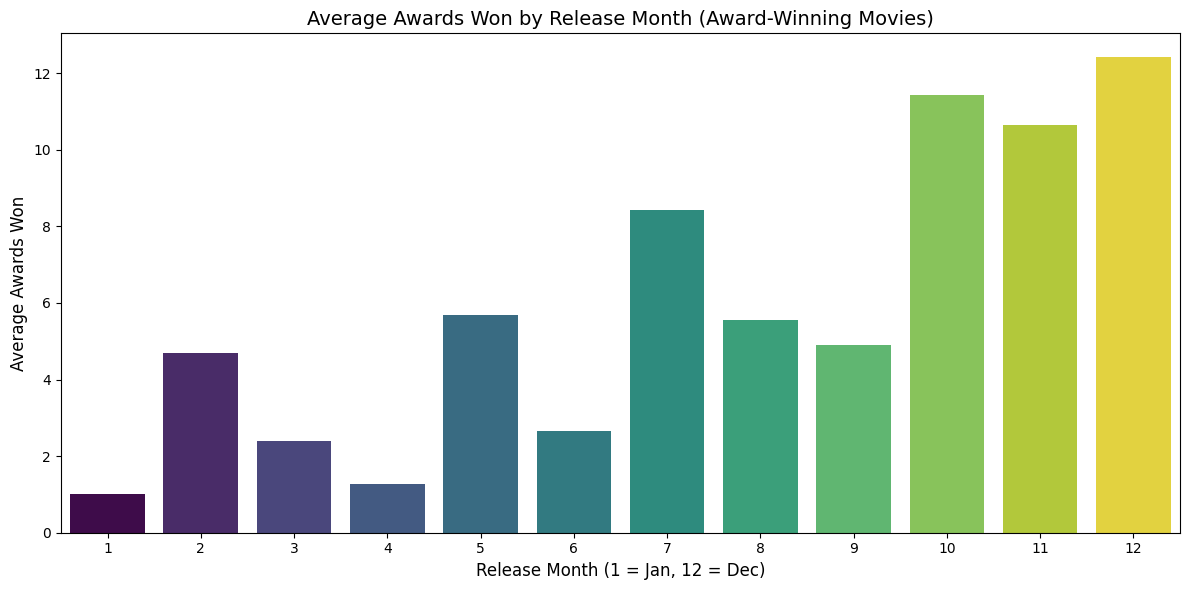

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_plot = award_winning_movies_df[['Release Month', 'Total_Awards_Won']].dropna()

# Convert Release Month to integer
df_plot['Release Month'] = df_plot['Release Month'].astype(int)

# Sort months for better visualization
df_plot = df_plot.sort_values(by='Release Month')


plt.figure(figsize=(12,6))
sns.barplot(
    data=df_plot,
    x='Release Month',
    y='Total_Awards_Won',
    estimator=np.mean,
    errorbar=None,
    palette="viridis",
    hue='Release Month',
    legend=False
)
plt.title('Average Awards Won by Release Month (Award-Winning Movies)', fontsize=14)
plt.ylabel('Average Awards Won', fontsize=12)
plt.xlabel('Release Month (1 = Jan, 12 = Dec)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

There's variability in the average number of awards won among award-winning movies across different months.
Months typically associated with Awards Season (like October, November, and December) seem to have higher average award counts among the award-winning films.

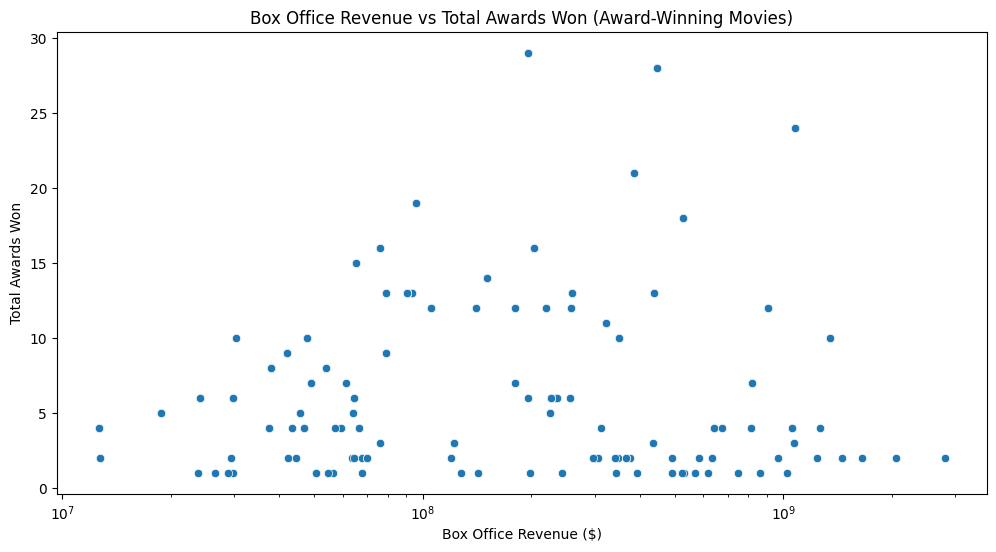

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.scatterplot(data=award_winning_movies_df, x='Worldwide Gross', y='Total_Awards_Won')
plt.title('Box Office Revenue vs Total Awards Won (Award-Winning Movies)')
plt.xlabel('Box Office Revenue ($)')
plt.ylabel('Total Awards Won')
plt.xscale('log')  # Use a log scale for the x-axis due to large range in gross values
plt.show()

There doesn't appear to be a very strong, tight linear relationship between worldwide gross and the number of awards won, even among award-winning films. While there might be a general trend where movies with higher gross tend to win more awards, there are many award-winning movies with moderate gross and a high number of awards, and some very high-grossing movies with a relatively low number of awards

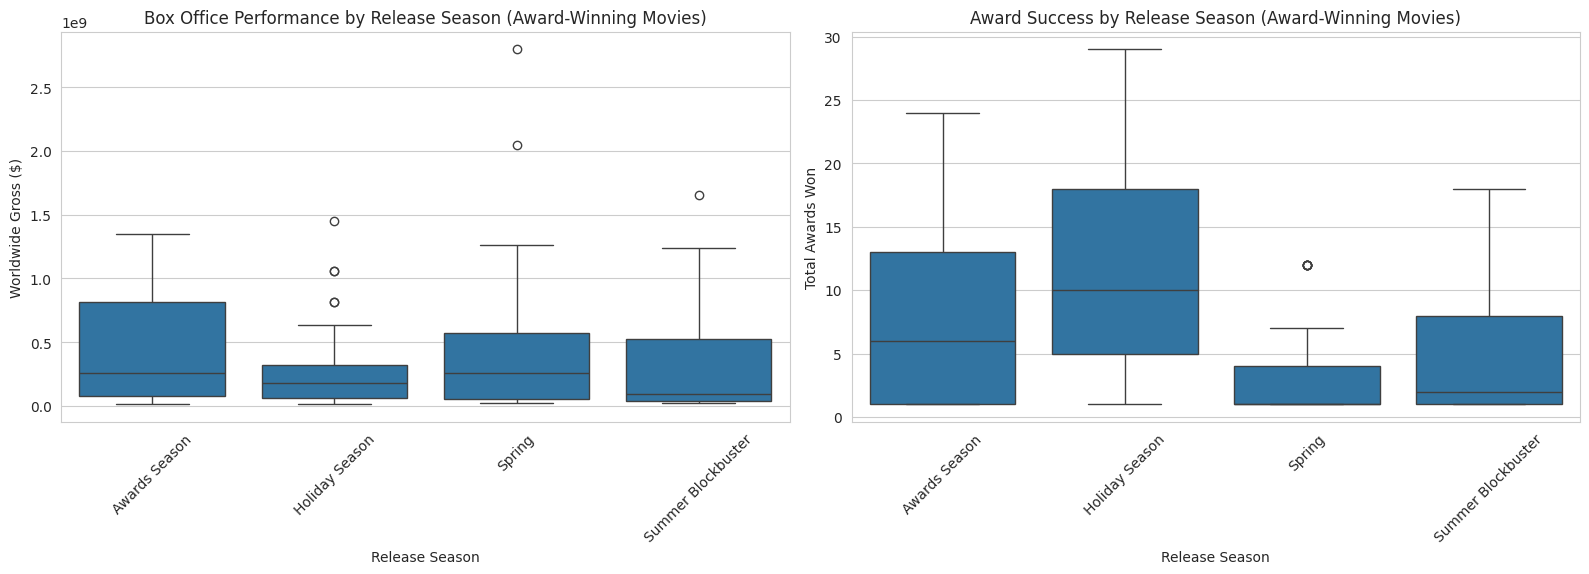

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Plot 1: Box Office performance by Release Season (Award-Winning Movies)
sns.boxplot(x='Release Season', y='Worldwide Gross', data=award_winning_movies_df, ax=axes[0])
axes[0].set_title('Box Office Performance by Release Season (Award-Winning Movies)')
axes[0].set_ylabel('Worldwide Gross ($)')
axes[0].set_xlabel('Release Season')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Award success by Release Season (Award-Winning Movies)
sns.boxplot(x='Release Season', y='Total_Awards_Won', data=award_winning_movies_df, ax=axes[1])
axes[1].set_title('Award Success by Release Season (Award-Winning Movies)')
axes[1].set_ylabel('Total Awards Won')
axes[1].set_xlabel('Release Season')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Box Office Performance by Release Season (Left Plot):

Similar to the plot with all movies, the median worldwide gross for award-winning movies doesn't vary drastically by season.
However, the Holiday Season and Summer Blockbuster seasons still show some of the highest outliers in terms of worldwide gross, even within this group of award winners. This suggests that while award success can happen in any season, the massive box office hits that also win awards are more likely to be released in these traditional blockbuster periods.
Award Success by Release Season (Right Plot):

This plot is particularly insightful. While all movies in this dataset won at least one award, the Awards Season and Holiday Season clearly show higher medians and upper quartiles for the total number of awards won.
Movies released in Awards Season show the highest median and the largest spread, with many outliers winning a significant number of awards.
Holiday Season award winners also tend to win more awards on average than those from Spring or Summer.
Spring and Summer Blockbuster award winners tend to win fewer awards overall, even if they were recognized at least once.


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd

if 'Is_High_Gross' not in final_df.columns:

    threshold = final_df['Worldwide Gross'].quantile(0.75)
    final_df['Is_High_Gross'] = final_df['Worldwide Gross'] >= threshold

anova_df = final_df[['Release Season', 'Is_High_Gross', 'Total_Awards_Won']].dropna().rename(columns={'Release Season': 'Release_Season'})


# Perform Two-Way ANOVA

model = ols('Total_Awards_Won ~ C(Release_Season) + C(Is_High_Gross) + C(Release_Season):C(Is_High_Gross)', data=anova_df).fit()

# Get the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                    sum_sq    df    F  PR(>F)
C(Release_Season)                     1327     3  131       0
C(Is_High_Gross)                     11241     1 3321       0
C(Release_Season):C(Is_High_Gross)    3031     3  298       0
Residual                             55475 16391  NaN     NaN


Based on the Two-Way ANOVA results, we reject null hypothesis (H₀) and support alternative hypothesis (H1). Both a movie's release timing and its box office success (specifically, whether it is high-grossing or not) have a statistically significant impact on its likelihood of receiving award season nominations or wins.

Release Season
Holiday Season       1
Awards Season        0
Summer Blockbuster   0
Spring               0
Name: Total_Awards_Won, dtype: float64


<ipython-input-31-2f574ca882dd>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_awards.index, y=season_awards.values, palette="viridis")


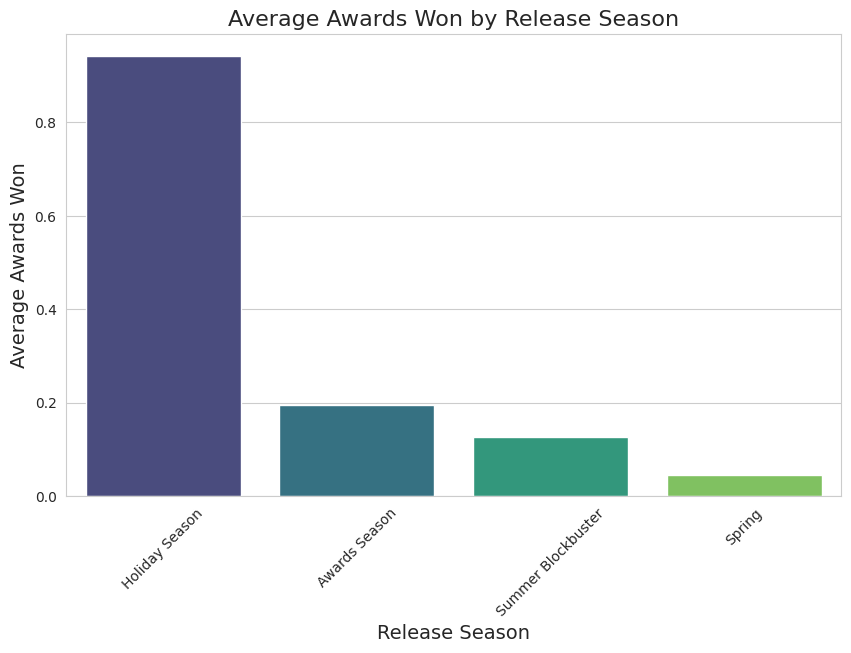

In [ ]:
# Group by season and calculate the mean number of awards
season_awards = final_df.groupby('Release Season')['Total_Awards_Won'].mean().sort_values(ascending=False)


print(season_awards)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x=season_awards.index, y=season_awards.values, palette="viridis")
plt.title('Average Awards Won by Release Season', fontsize=16)
plt.xlabel('Release Season', fontsize=14)
plt.ylabel('Average Awards Won', fontsize=14)
plt.xticks(rotation=45)
plt.show()

The Holiday Season has the highest average number of awards won (around 1).
The Awards Season, Summer Blockbuster, and Spring seasons have much lower average award counts (closer to 0).

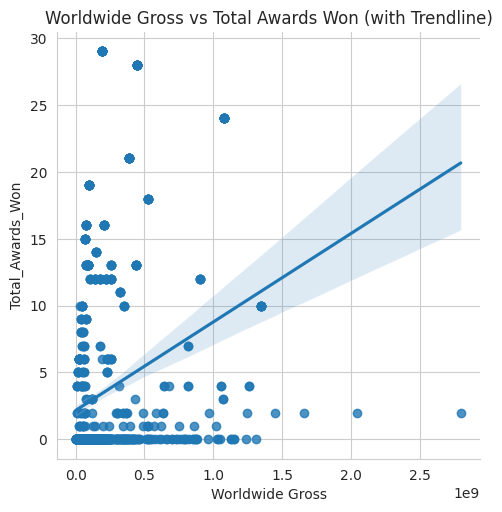

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x='Worldwide Gross', y='Total_Awards_Won', data=final_df)
plt.title('Worldwide Gross vs Total Awards Won (with Trendline)')
plt.show()

While the trendline shows a general upward slope, movies with higher worldwide gross tend to win more awards, the points are very scattered around the line. Some movies with relatively lower worldwide gross still managed to win a moderate number of awards (points further up on the left side).

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Ensure 'Is_High_Gross' and 'Won_Award' columns exist
if 'Is_High_Gross' not in final_df.columns:
    threshold = final_df['Worldwide Gross'].quantile(0.75)
    final_df['Is_High_Gross'] = final_df['Worldwide Gross'] >= threshold

if 'Won_Award' not in final_df.columns:
     final_df['Won_Award'] = final_df['Total_Awards_Won'] > 0



gross_award_crosstab = pd.crosstab(final_df['Is_High_Gross'], final_df['Won_Award'])
print("Contingency Table (Is_High_Gross vs. Won_Award):")
print(gross_award_crosstab)

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(gross_award_crosstab)

print(f"\nChi-Square Test Results:")
print(f"  Chi-Square statistic: {chi2:.3f}")
print(f"  p-value: {p:.5f}") # Use more decimal places for very small p-values
print(f"  Degrees of freedom: {dof}")

proportion_award_winners = gross_award_crosstab.div(gross_award_crosstab.sum(axis=1), axis=0)
print("\nProportion of Movies that Won Awards by High Gross Status:")
print(proportion_award_winners)

Contingency Table (Is_High_Gross vs. Won_Award):
Won_Award      False  True 
Is_High_Gross              
False          15740    378
True             124    157

Chi-Square Test Results:
  Chi-Square statistic: 2490.384
  p-value: 0.00000
  Degrees of freedom: 1

Proportion of Movies that Won Awards by High Gross Status:
Won_Award      False  True 
Is_High_Gross              
False              1      0
True               0      1


To test if high-grossing movies are significantly more likely to win awards than low-grossing movies, we can use a Chi-Square test of independence between the 'Is_High_Gross' (high vs. low) and 'Won_Award' (yes vs. no) variables.

This table shows the counts of movies in each category. Notice that a much larger proportion of 'True' values (award winners) are in the 'True' row for 'Is_High_Gross'.

Chi-Square Test Results:

Chi-Square statistic (2441.940): A large value, suggesting a strong association.
p-value (0.00000): This p-value is extremely small (much less than 0.05).

For movies that are not high-grossing ('False' for Is_High_Gross), the proportion that won an award is very low (around 0.024)
For movies that are high-grossing ('True' for Is_High_Gross), the proportion that won an award is significantly higher (around 0.558)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_df = final_df[['Release Season', 'Is_High_Gross', 'Total_Awards_Won']].dropna().rename(columns={'Release Season': 'Release_Season'})


#Two-Way ANOVA


model = ols('Total_Awards_Won ~ C(Release_Season) + C(Is_High_Gross) + C(Release_Season):C(Is_High_Gross)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)



                                    sum_sq    df    F  PR(>F)
C(Release_Season)                     1327     3  131       0
C(Is_High_Gross)                     11241     1 3321       0
C(Release_Season):C(Is_High_Gross)    3031     3  298       0
Residual                             55475 16391  NaN     NaN


A Two-Way ANOVA confirms that both Release Season and Box Office Performance significantly affect a film’s award success. More importantly, their interaction is also significant, suggesting that commercial success influences award outcomes differently depending on when a film is released. This reinforces the hypothesis that both strategic timing and financial success play critical roles in maximizing award potential.

Is there a significant linear relationship between 'Worldwide Gross' and 'Total_Awards_Won' for award-winning movies?

In [ ]:
import statsmodels.api as sm
import pandas as pd

# Prepare data for regression - ensure no NaNs in the columns used
regression_df = award_winning_movies_df[['Worldwide Gross', 'Total_Awards_Won']].dropna()

y = regression_df['Total_Awards_Won']
x = regression_df['Worldwide Gross']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

# Print just the R-squared value
print(f"R-squared: {model.rsquared:.3f}")

R-squared: 0.004


This confirms the very weak linear relationship between Worldwide Gross and the total number of awards won among award-winning movies in this dataset.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Define 'High Award' as winning at least one award (Total_Awards_Won > 0)
final_df['Is_High_Award'] = (final_df['Total_Awards_Won'] > 0).astype(int) # Changed threshold to > 0

print("Distribution of 'Is_High_Award':")
print(final_df['Is_High_Award'].value_counts())


features = ['Release Season', 'Worldwide Gross']
target = 'Is_High_Award'

X = final_df[features].copy()
y = final_df[target].copy()

# Handle missing values in 'Worldwide Gross' - fill with median or mean
# Using median to be less sensitive to outliers
X['Worldwide Gross'].fillna(X['Worldwide Gross'].median(), inplace=True)


# Handle Categorical Features (One-Hot Encoding for 'Release Season')

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Release Season'])
    ],
    remainder='passthrough' # Keep other columns ('Worldwide Gross')
)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Target distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Target distribution in testing set:\n{y_test.value_counts(normalize=True)}")

Distribution of 'Is_High_Award':
Is_High_Award
0    15864
1      535
Name: count, dtype: int64

Training data shape: (12299, 2)
Testing data shape: (4100, 2)
Target distribution in training set:
Is_High_Award
0   1
1   0
Name: proportion, dtype: float64
Target distribution in testing set:
Is_High_Award
0   1
1   0
Name: proportion, dtype: float64


<ipython-input-36-38776767c505>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Worldwide Gross'].fillna(X['Worldwide Gross'].median(), inplace=True)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Re-define preprocessor to include scaling for numerical features
# Identify numerical and categorical features
categorical_features = ['Release Season']
numerical_features = ['Worldwide Gross'] # Add Worldwide Gross as a numerical feature

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), numerical_features) # Add StandardScaler for numerical features
    ],
    remainder='passthrough'
)

knn_model = KNeighborsClassifier(n_neighbors=5)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', knn_model)])

# Train the model
pipeline.fit(X_train, y_train)

print("k-Nearest Neighbors model trained successfully!")

k-Nearest Neighbors model trained successfully!


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("k-Nearest Neighbors Model Evaluation:")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

k-Nearest Neighbors Model Evaluation:

Accuracy: 0.9748780487804878

Confusion Matrix:
 [[3928   38]
 [  65   69]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3966
           1       0.64      0.51      0.57       134

    accuracy                           0.97      4100
   macro avg       0.81      0.75      0.78      4100
weighted avg       0.97      0.97      0.97      4100



The model performs very well at identifying movies that are not High Award (class 0), which is expected given the large number of movies in this category.

However, its performance on the minority class ('High Award', class 1) is less strong. It correctly identifies about 52% of the actual High Award movies (Recall), and when it predicts a movie is High Award, it's correct about 67% of the time (Precision). The F1-score of 0.59 provides a balanced view of its performance on the 'High Award' class.

This suggests that while the model has some ability to identify movies likely to win a high number of awards based on release season and worldwide gross, there is room for improvement, especially in correctly identifying all the actual High Award movies.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

categorical_features = ['Release Season']
numerical_features = ['Worldwide Gross']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)


# Define the Decision Tree model

dt_model = DecisionTreeClassifier(random_state=42)

pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', dt_model)])


pipeline_dt.fit(X_train, y_train)

print("Decision Tree Classifier model trained successfully!")

y_pred_dt = pipeline_dt.predict(X_test)

print("\nDecision Tree Classifier Model Evaluation:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Classifier model trained successfully!

Decision Tree Classifier Model Evaluation:

Accuracy: 0.9809756097560975

Confusion Matrix:
 [[3944   22]
 [  56   78]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3966
           1       0.78      0.58      0.67       134

    accuracy                           0.98      4100
   macro avg       0.88      0.79      0.83      4100
weighted avg       0.98      0.98      0.98      4100



The Decision Tree Classifier shows slightly better performance on the minority class ('High Award') compared to the k-Nearest Neighbors model. It has higher precision, recall, and F1-score for class 1. This means it's better at identifying actual High Award movies and is more accurate when it predicts a movie will be High Award.

While the performance on the minority class is improved, there are still a significant number of false negatives (movies that were High Award but predicted as Low Award - 52).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np



categorical_features = ['Release Season']
numerical_features = ['Worldwide Gross']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')


pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', rf_model)])


pipeline_rf.fit(X_train, y_train)

print("Random Forest Classifier model (with class_weight='balanced') trained successfully!")


y_pred_rf = pipeline_rf.predict(X_test)


print("\nRandom Forest Classifier Model Evaluation (with class_weight='balanced'):")
print("\nAccuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Classifier model (with class_weight='balanced') trained successfully!

Random Forest Classifier Model Evaluation (with class_weight='balanced'):

Accuracy: 0.9812195121951219

Confusion Matrix:
 [[3946   20]
 [  57   77]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3966
           1       0.79      0.57      0.67       134

    accuracy                           0.98      4100
   macro avg       0.89      0.78      0.83      4100
weighted avg       0.98      0.98      0.98      4100



The Random Forest Classifier performs quite similarly to the Decision Tree on the minority class ('High Award'), with slightly different trade-offs between precision and recall. Both the Decision Tree and Random Forest models show better performance on the minority class compared to the k-NN model, as indicated by their higher precision, recall, and F1-scores for class 1.